# Librairies

In [228]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString, MultiLineString, Polygon
import matplotlib.pylab as plt
from tqdm import tqdm

# Load traffic dada

In [229]:
df = pd.read_csv('raw/MMM_MMM_Comptage.csv')

In [230]:
df.columns

Index(['objectid', 'id_centrale', 'code_centrale', 'libelle_centrale', 'annee',
       'libelle_groupage', 'type_compteur', 'type_comptage', 'nb_canaux',
       'nb_annee', 'code_canal', 'mja_jo', 'mja_tcj', 'mja_pl_tcj',
       'hp_johvs_matin', 'hp_johvs_soir', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj',
       'descriptif_periode', 'time_days', 'name', 'oneway', 'ref_mmm',
       'highway', 'nom_commune', 'cycles', 'osm_id'],
      dtype='object')

In [231]:
df.nb_canaux.value_counts()

nb_canaux
3    9000
1     317
2       4
Name: count, dtype: int64

In [232]:
df.annee.unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011], dtype=int64)

In [233]:
df.type_comptage.unique()

array(['comptage bidirectionnel', 'comptage unidirectionnel', 'NR'],
      dtype=object)

In [234]:
df.cycles.unique()

array([' ', 'Bande cyclable droite', 'Bande cyclable',
       'Voie verte et assimilé', 'Piste cyclable', nan,
       'Bande cyclable gauche'], dtype=object)

In [235]:
# Remove data relative to bicycles
print(df.shape)
df  = df[df.cycles == " "]
print(df.shape)

(9321, 28)
(7790, 28)


In [236]:
# Duplicated values
df.duplicated(subset=['annee', 'osm_id']).sum()

5153

In [237]:
df.libelle_groupage.value_counts()

libelle_groupage
Sens cumulés                  2534
6300.00 2                       45
6300.00 1                       45
Le Cres_Vendargues              24
Clapiers_Castelnau              24
                              ... 
Droits de l'Homme_Moulares       1
Ecrin_Grillons                   1
Grillons_Ecrin                   1
Pilory_Bausch                    1
Richier-Camproux                 1
Name: count, Length: 2699, dtype: int64

In [238]:
df.type_compteur.value_counts()

type_compteur
compteur ponctuel         4978
compteur permanent        1522
compteur tournant          876
compteur feux              411
compteur ponctuel vélo       3
Name: count, dtype: int64

In [239]:
# Remove bikes
df = df[~df.type_compteur.isin(['compteur ponctuel vélo'])]

In [240]:
# Replace 0 values by nan
df.loc[df.mja_jo == 0, 'mja_jo'] = np.nan
df.loc[df.mja_tcj == 0, 'mja_tcj'] = np.nan

In [241]:
df.dropna(subset = ['mja_jo', 'mja_tcj'], inplace=True)

In [242]:
df.columns

Index(['objectid', 'id_centrale', 'code_centrale', 'libelle_centrale', 'annee',
       'libelle_groupage', 'type_compteur', 'type_comptage', 'nb_canaux',
       'nb_annee', 'code_canal', 'mja_jo', 'mja_tcj', 'mja_pl_tcj',
       'hp_johvs_matin', 'hp_johvs_soir', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj',
       'descriptif_periode', 'time_days', 'name', 'oneway', 'ref_mmm',
       'highway', 'nom_commune', 'cycles', 'osm_id'],
      dtype='object')

In [243]:
# Understanding columns
df[(df.osm_id ==  244106263) & (df.annee == 2022)][['libelle_groupage', 'type_compteur', 'type_comptage',
      'mja_jo', 'mja_tcj', 'mja_pl_tcj', 'descriptif_periode', 'time_days',
        'name', 'oneway', 'ref_mmm',
       'highway', 'nom_commune', 'cycles', 'osm_id']]

,libelle_groupage,type_compteur,type_comptage,mja_jo,mja_tcj,mja_pl_tcj,descriptif_periode,time_days,name,oneway,ref_mmm,highway,nom_commune,cycles,osm_id
2515,Sens cumulés,compteur tournant,comptage bidirectionnel,2159.0,1859.0,6.0,du 05/03/2022 au 21/11/2022,261.0,,UNKNOWN,,tertiary,Villeneuve-lès-Maguelone,,244106263.0
2516,RM116E2_RM185,compteur tournant,comptage bidirectionnel,1478.0,1265.0,2.0,du 05/03/2022 au 21/11/2022,261.0,,UNKNOWN,,tertiary,Villeneuve-lès-Maguelone,,244106263.0
2517,RM185_RM116E2,compteur tournant,comptage bidirectionnel,681.0,594.0,4.0,du 05/03/2022 au 21/11/2022,261.0,,UNKNOWN,,tertiary,Villeneuve-lès-Maguelone,,244106263.0


In [244]:
print(681+1478)

2159


In [245]:
# Geometry (osmid) is the same for directionnal and non -directional flow so we'll keep aggregated values where available 
# For other cases we keep directed flow

In [246]:
c1 = 0
c2 = 0
c3 = 0
l_df = []
l_const = []
for code in tqdm(df.osm_id.unique()):
    for year in df[df.osm_id == code].annee.unique():
        sub = df[(df.osm_id == code) & (df.annee == year)]
        if 'Sens cumulés' not in sub.libelle_groupage.values:
            # Do we have both directions and we just need to sum ?
            if sub.libelle_groupage.values.size == 2:
                c2+=1
                l_const.append(pd.DataFrame(index = [1],
                                            data={
                                'annee':year,
                                'osm_id' : code,
                                'libelle_groupage': 'Sens cumulés',
                                'mja_jo' :  sub.mja_jo.sum(), 
                                'mja_tcj' : sub.mja_tcj.sum(), 
                                'mja_pl_tcj' :  sub.mja_pl_tcj.sum(), 
                                'v85ma_tcj' :  sub.v85ma_tcj.mean(), 
                                'vtma_tcj' :  sub.vtma_tcj.mean(),
                                
                                # Cannot aggregate
                                'type_compteur' : np.nan
                                
                                        }))
            elif  sub.libelle_groupage.values.size == 1:
            # In that case we only have oneway (this is quite rare)
                c1+=1
                l_df.append(sub)
            elif sub.libelle_groupage.values.size == 3 :
                i = sub
                c3+=1
            else : 
                print(sub)
df_directed = pd.concat(l_df)
df_const = pd.concat(l_const)

100%|██████████| 1271/1271 [00:02<00:00, 478.27it/s]


In [247]:
i

,objectid,id_centrale,code_centrale,libelle_centrale,annee,libelle_groupage,type_compteur,type_comptage,nb_canaux,nb_annee,...,vtma_tcj,descriptif_periode,time_days,name,oneway,ref_mmm,highway,nom_commune,cycles,osm_id
1650,3514,83514,30929,MONTPELLIER. Rue de la Mediterranee,2023,Alsace_Girard,compteur ponctuel,comptage unidirectionnel,1,1,...,13.0,du 06/12/2023 au 12/12/2023,6.0,Rue de la Méditerranée,YES,,residential,Montpellier,,23634699.0
2408,7328,1292,8841,MONTPELLIER. Rue de la Mediterranee,2023,Aire_Tarragone,compteur ponctuel,comptage unidirectionnel,1,2,...,13.0,du 06/12/2023 au 12/12/2023,6.0,Rue de la Méditerranée,YES,,residential,Montpellier,,23634699.0
2409,7329,1037,8842,MONTPELLIER. Rue de la Mediterranee,2023,Girard_Aire,compteur ponctuel,comptage unidirectionnel,1,2,...,23.0,du 06/12/2023 au 12/12/2023,6.0,Rue de la Méditerranée,YES,,residential,Montpellier,,23634699.0


In [248]:
print(c1, c2, c3)

201 5 1


In [249]:
df[(df.osm_id == 636132802.0) & (df.annee == 2024)][:20]

,objectid,id_centrale,code_centrale,libelle_centrale,annee,libelle_groupage,type_compteur,type_comptage,nb_canaux,nb_annee,...,vtma_tcj,descriptif_periode,time_days,name,oneway,ref_mmm,highway,nom_commune,cycles,osm_id
346,2770,55923,184495,MONTPELLIER. Rue du Professeur Forgue,2024,Liberte_Lodeve,compteur ponctuel,comptage unidirectionnel,1,2,...,26.0,du 22/05/2024 au 30/05/2024,8.0,Rue du Professeur Forgue,UNKNOWN,,residential,Montpellier,,636132802.0
380,7735,969,200576,MONTPELLIER. Rue du Professeur Forgues,2024,Lodeve_Liberte,compteur feux,comptage unidirectionnel,1,10,...,NaN,du 30/04/2024 au 30/04/2024,0.0,Rue du Professeur Forgue,UNKNOWN,,residential,Montpellier,,636132802.0


In [250]:
df_const

,annee,osm_id,libelle_groupage,mja_jo,mja_tcj,mja_pl_tcj,v85ma_tcj,vtma_tcj,type_compteur
1,2024,636132802.0,Sens cumulés,3164.0,3038.0,25.0,38.0,26.0,NaN
1,2023,47203042.0,Sens cumulés,6332.0,5723.0,39.0,42.0,31.5,NaN
1,2023,120823006.0,Sens cumulés,3045.0,2783.0,0.0,30.0,19.0,NaN
1,2023,26187984.0,Sens cumulés,917.0,846.0,6.0,44.0,31.5,NaN
1,2020,22906463.0,Sens cumulés,2510.0,2283.0,42.0,48.5,37.5,NaN


In [251]:
df = pd.concat(
    [
        df[df.libelle_groupage == 'Sens cumulés'],
        df_directed,
        df_const
    ]
)

In [252]:
df[['osm_id', 'annee']].duplicated().sum()

113

In [253]:
df[['osm_id', 'annee', 'libelle_groupage', 'type_compteur']].duplicated().sum()
# Still duplicates that are coming from the same year

104

In [254]:
df[(df.osm_id ==  28889245) & (df.annee == 2022)][['libelle_groupage', 'type_compteur', 'type_comptage',
      'mja_jo', 'mja_tcj', 'mja_pl_tcj', 'descriptif_periode', 'time_days', 'annee',
       'hp_johvs_matin', 'hp_johvs_soir', 'tir_tcj', 'v85ma_tcj', 'vtma_tcj', 'osm_id']]

,libelle_groupage,type_compteur,type_comptage,mja_jo,mja_tcj,mja_pl_tcj,descriptif_periode,time_days,annee,hp_johvs_matin,hp_johvs_soir,tir_tcj,v85ma_tcj,vtma_tcj,osm_id
2845,Sens cumulés,compteur ponctuel,comptage bidirectionnel,1622.0,1485.0,8.0,du 15/05/2022 au 23/05/2022,8.0,2022,NaN,NaN,NaN,NaN,NaN,28889245.0
2851,Sens cumulés,compteur ponctuel,comptage bidirectionnel,4234.0,3898.0,49.0,du 15/05/2022 au 23/05/2022,8.0,2022,NaN,NaN,NaN,NaN,NaN,28889245.0
3250,Sens cumulés,compteur ponctuel,comptage bidirectionnel,1396.0,1280.0,4.0,du 15/05/2022 au 23/05/2022,8.0,2022,NaN,NaN,NaN,NaN,NaN,28889245.0


In [255]:
df.shape

(2736, 28)

In [256]:
# Take the average value over the year

df = df.groupby(['osm_id', 'annee', 'libelle_groupage']).agg(
      AAWT = ('mja_jo', 'mean'),
      AADT = ('mja_tcj', 'mean'), 
      TR_AADT = ('mja_pl_tcj', 'mean'), 
      s85 = ('v85ma_tcj', 'mean'),
      savg = ('vtma_tcj', 'mean'),
      raw_techno = ('type_compteur', lambda x : x.iloc[0] if x.unique().size == 1 else str(x.values) )
      )
df.shape

(2623, 6)

In [257]:
df

AAWT     AADT  TR_AADT  s85  savg  \
osm_id      annee libelle_groupage                                         
4082887.0   2018  Sens cumulés      20986.0  19672.0      NaN  NaN   NaN   
            2022  Sens cumulés       8606.0   7966.0      NaN  NaN   NaN   
4270410.0   2023  Sens cumulés       2156.0   1916.0      4.0  NaN   NaN   
4296699.0   2023  Sens cumulés      27704.0  26607.0   1104.0  NaN   NaN   
            2024  Sens cumulés      24565.0  23602.0   1070.0  NaN   NaN   
...                                     ...      ...      ...  ...   ...   
842005118.0 2021  Sens cumulés       4110.0   3591.0    163.0  NaN   NaN   
            2022  Sens cumulés       4056.0   3608.0    144.0  NaN   NaN   
            2023  Sens cumulés       4344.0   3867.0    193.0  NaN   NaN   
            2024  Sens cumulés       3909.0   3483.0    185.0  NaN   NaN   
842658460.0 2021  Sens cumulés        564.0    536.0     12.0  NaN   NaN   

                                            raw_techno  
osm_id      annee libelle_groupage                      
4082887.0   2018  Sens cumulés       compteur ponctuel  
            2022  Sens cumulés       compteur ponctuel  
4270410.0   2023  Sens cumulés       compteur ponctuel  
4296699.0   2023  Sens cumulés      compteur permanent  
            2024  Sens cumulés      compteur permanent  
...                                                ...  
842005118.0 2021  Sens cumulés       compteur tournant  
            2022  Sens cumulés       compteur tournant  
            2023  Sens cumulés       compteur tournant  
            2024  Sens cumulés       compteur tournant  
842658460.0 2021  Sens cumulés       compteur ponctuel  

[2623 rows x 6 columns]

# Load referential

In [258]:
ref = pd.read_csv('raw/OSM_MMM_Filaire.csv')

C:\Users\xbonnema\AppData\Local\Temp\ipykernel_23096\3533074052.py:1: DtypeWarning: Columns (22,25,26,50,62,64,71,74,93) have mixed types. Specify dtype option on import or set low_memory=False.
  ref = pd.read_csv('raw/OSM_MMM_Filaire.csv')


In [259]:
# All osm attributes are already present in the data
ref.columns

Index(['objectid', 'osm_id', 'length_m', 'name', 'source', 'target',
       'source_osm', 'target_osm', 'cost', 'reverse_cost', 'cost_s',
       'reverse_cost_s', 'oneway', 'x1', 'y1', 'x2', 'y2', 'maxspeed_forward',
       'maxspeed_backward', 'priority', 'access', 'alt_name', 'barrier',
       'bicycle', 'bridge', 'busway', 'busway_left', 'busway_right',
       'construction', 'covered', 'crossing', 'cycleway', 'cycleway_both',
       'cycleway_left', 'cycleway_right', 'foot', 'footway', 'highway',
       'junction', 'kerb', 'lanes', 'lanes_backward', 'lanes_forward',
       'lanes_psv', 'lanes_psv_backward', 'lanes_psv_forward', 'layer',
       'loc_name', 'maxheight', 'maxspeed', 'motor_vehicle_conditional',
       'noname', 'oneway_bicycle', 'parking_lane_both', 'parking_lane_left',
       'parking_lane_right', 'psv', 'railway', 'ref', 'ref_mmm', 'service',
       'sidewalk', 'status', 'surface', 'tactile_paving', 'tracktype',
       'traffic_calming', 'tunnel', 'turn_lanes', 'typ

In [260]:
# We just need to apply some treatment to it
ref[['name', 'highway', 'lanes',  'lanes_backward', 'lanes_forward', 'oneway', ]]

,name,highway,lanes,lanes_backward,lanes_forward,oneway
0,NaN,footway,NaN,NaN,NaN,UNKNOWN
1,Rue Edmond Halley,residential,NaN,NaN,NaN,UNKNOWN
2,Rue des Cétoines,residential,NaN,NaN,NaN,no
3,Rue Henri Dunant,primary,4.0,NaN,NaN,UNKNOWN
4,Rue des Mourguettes,residential,NaN,NaN,NaN,UNKNOWN
...,...,...,...,...,...,...
116106,Rue Viala,residential,NaN,NaN,NaN,UNKNOWN
116107,NaN,track,NaN,NaN,NaN,UNKNOWN
116108,Passage Lonjon,pedestrian,NaN,NaN,NaN,UNKNOWN
116109,NaN,unclassified,NaN,NaN,NaN,UNKNOWN


In [261]:
ref['oneway'].value_counts()

oneway
UNKNOWN        91993
yes            21415
no              2674
-1                24
alternating        5
Name: count, dtype: int64

In [262]:
l = []
for k in tqdm(ref.index):
    oneway = ref.loc[k].oneway
    if oneway == 'UNKNOWN':
        if np.isnan(ref.loc[k].lanes_backward) & np.isnan(ref.loc[k].lanes_forward) :
            # Then we have no information
            l.append(np.nan)
        else :
            l.append(False)
    elif oneway == 'yes':
        l.append(True)
    elif oneway == 'no':
        l.append(False)
    else :
        l.append(oneway)

  0%|          | 498/116111 [00:00<00:51, 2246.92it/s]

100%|██████████| 116111/116111 [00:29<00:00, 3948.07it/s]


In [263]:
ref['osm_oneway'] = l
ref[['name', 'highway', 'lanes',  'lanes_backward', 'lanes_forward', 'oneway', 'osm_oneway']]

,name,highway,lanes,lanes_backward,lanes_forward,oneway,osm_oneway
0,NaN,footway,NaN,NaN,NaN,UNKNOWN,NaN
1,Rue Edmond Halley,residential,NaN,NaN,NaN,UNKNOWN,NaN
2,Rue des Cétoines,residential,NaN,NaN,NaN,no,False
3,Rue Henri Dunant,primary,4.0,NaN,NaN,UNKNOWN,NaN
4,Rue des Mourguettes,residential,NaN,NaN,NaN,UNKNOWN,NaN
...,...,...,...,...,...,...,...
116106,Rue Viala,residential,NaN,NaN,NaN,UNKNOWN,NaN
116107,NaN,track,NaN,NaN,NaN,UNKNOWN,NaN
116108,Passage Lonjon,pedestrian,NaN,NaN,NaN,UNKNOWN,NaN
116109,NaN,unclassified,NaN,NaN,NaN,UNKNOWN,NaN


In [264]:
l_geom = list()
#for k in tqdm(ref.index) :
for x1, y1, x2, y2 in ref[['x1', 'y1', 'x2', 'y2']].values:
    # Create the geometry
    l_geom.append(LineString([[x1, y1], [x2, y2]]))
    
ref['geometry'] = l_geom

In [265]:
ref = gpd.GeoDataFrame(ref, geometry='geometry', crs = 'epsg:4326')

(3.50284833, 4.24395727, 43.44552445, 43.82380015)

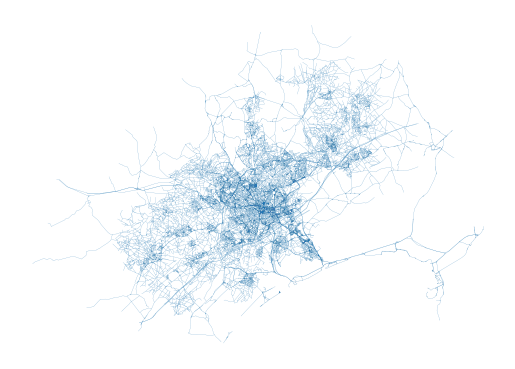

In [266]:
ref[['geometry']].plot(lw = .1)
plt.axis('off')

In [267]:
ref = ref[['name', 'highway', 'lanes',  'osm_oneway', 'osm_id', 'geometry' ]]

# Join

In [268]:
jf = df.join(ref.set_index('osm_id'), on = 'osm_id', how = 'inner').reset_index()

In [269]:
jf.columns

Index(['osm_id', 'annee', 'libelle_groupage', 'AAWT', 'AADT', 'TR_AADT', 's85',
       'savg', 'raw_techno', 'name', 'highway', 'lanes', 'osm_oneway',
       'geometry'],
      dtype='object')

In [274]:
jf.rename(columns = {
   'osm_id' : 'osmid', 
   'libelle_groupage' : 'raw_direction', 
     'name' : 'osm_name', 
     'highway' : 'osm_type', 
     'lanes' : 'osm_lanes',
}, inplace=True)
jf

,osmid,annee,raw_direction,AAWT,AADT,TR_AADT,s85,savg,raw_techno,osm_name,osm_type,osm_lanes,osm_oneway,geometry
0,4082887.0,2018,Sens cumulés,20986.0,19672.0,NaN,NaN,NaN,compteur ponctuel,Pont Jean Zuccarelli,secondary,2.0,NaN,"LINESTRING (3.89713 43.60063, 3.89632 43.60021)"
1,4082887.0,2022,Sens cumulés,8606.0,7966.0,NaN,NaN,NaN,compteur ponctuel,Pont Jean Zuccarelli,secondary,2.0,NaN,"LINESTRING (3.89713 43.60063, 3.89632 43.60021)"
2,4270410.0,2023,Sens cumulés,2156.0,1916.0,4.0,NaN,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,"LINESTRING (4.03609 43.6514, 4.03504 43.65235)"
3,4270410.0,2023,Sens cumulés,2156.0,1916.0,4.0,NaN,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,"LINESTRING (4.03504 43.65235, 4.03428 43.65319)"
4,4270410.0,2023,Sens cumulés,2156.0,1916.0,4.0,NaN,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,"LINESTRING (4.03428 43.65319, 4.03213 43.65679)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11462,842005118.0,2024,Sens cumulés,3909.0,3483.0,185.0,NaN,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,"LINESTRING (3.95731 43.66313, 3.95557 43.66442)"
11463,842005118.0,2024,Sens cumulés,3909.0,3483.0,185.0,NaN,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,"LINESTRING (3.9624 43.66177, 3.96103 43.66196)"
11464,842005118.0,2024,Sens cumulés,3909.0,3483.0,185.0,NaN,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,"LINESTRING (3.96103 43.66196, 3.95984 43.66212)"
11465,842005118.0,2024,Sens cumulés,3909.0,3483.0,185.0,NaN,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,"LINESTRING (3.95245 43.66659, 3.95181 43.6673)"


In [275]:
jf.raw_direction.value_counts()

raw_direction
Sens cumulés               10805
Saint Priest_Cardonille       30
Cordonille_Saint Loup         22
Verdanson_Belmont             14
Liberte_Pres d'Arenes         14
                           ...  
Toulouse_Jean Granier          1
Girard_Alsace                  1
Hazard_Hospices                1
Palavas_Pont Trinquat          1
Bornier_Pins                   1
Name: count, Length: 155, dtype: int64

In [276]:
jf['raw_oneway'] = jf['raw_direction'].apply(lambda x : True if x!= 'Sens cumulés' else False)
jf.loc[~jf.raw_oneway, 'raw_direction'] = np.nan

In [277]:
jf = gpd.GeoDataFrame(jf, geometry='geometry', crs = 'epsg:4326')

In [278]:
jf.dropna(subset = ['AADT', 'AAWT', 'geometry'], inplace=True)

# Final Saving

In [283]:
jf[jf.annee == 2023][[
        'AAWT', 'AADT', 'TR_AADT', 's85', 'savg', 'geometry', 'raw_oneway', 'raw_direction', 'raw_techno', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osmid',
        ]]

,AAWT,AADT,TR_AADT,s85,savg,geometry,raw_oneway,raw_direction,raw_techno,osm_name,osm_type,osm_lanes,osm_oneway,osmid
2,2156.0,1916.0,4.0,NaN,NaN,"LINESTRING (4.03609 43.6514, 4.03504 43.65235)",False,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,4270410.0
3,2156.0,1916.0,4.0,NaN,NaN,"LINESTRING (4.03504 43.65235, 4.03428 43.65319)",False,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,4270410.0
4,2156.0,1916.0,4.0,NaN,NaN,"LINESTRING (4.03428 43.65319, 4.03213 43.65679)",False,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,4270410.0
5,2156.0,1916.0,4.0,NaN,NaN,"LINESTRING (4.03612 43.65137, 4.03609 43.6514)",False,NaN,compteur ponctuel,Route de Saint-Brès,tertiary,NaN,NaN,4270410.0
6,27704.0,26607.0,1104.0,NaN,NaN,"LINESTRING (3.86439 43.58169, 3.86796 43.58012)",False,NaN,compteur permanent,Avenue du Colonel Pavelet,primary,2.0,True,4296699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11447,4344.0,3867.0,193.0,NaN,NaN,"LINESTRING (3.95764 43.66291, 3.95731 43.66313)",False,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,842005118.0
11448,4344.0,3867.0,193.0,NaN,NaN,"LINESTRING (3.95731 43.66313, 3.95557 43.66442)",False,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,842005118.0
11449,4344.0,3867.0,193.0,NaN,NaN,"LINESTRING (3.9624 43.66177, 3.96103 43.66196)",False,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,842005118.0
11450,4344.0,3867.0,193.0,NaN,NaN,"LINESTRING (3.96103 43.66196, 3.95984 43.66212)",False,NaN,compteur tournant,Route de Teyran,tertiary,NaN,NaN,842005118.0


In [284]:
# Saving
for year in range(2015, 2025) :
    # Extract corresponding year
    sub = jf[jf.annee == year]
    print(year, sub.shape[0])
    sub[[
        'AAWT', 'AADT', 'TR_AADT', 's85', 'savg', 'geometry', 'raw_oneway', 'raw_direction', 'raw_techno', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osmid',
        ]].to_file(f'treated/Montpellier_AADT_AAWT_{year}.geojson', index = False)

2015 476
2016 581
2017 669
2018 886
2019 881
2020 1046
2021 1058
2022 1608
2023 1950
2024 955
